# Sales Forecasting & Key Trends

**Quick Reference**
1. Project Plan
2. Imports
3. Acquire & Prep
4. Exploratory Data Analysis (EDA)
5. Models
6. Model Evaluation
7. Final Conclusions

## Project Plan

**Summary**

Use historical data to identify any key trends in the business, as well as develop a sales forecast for the marketing teams. 
Sections to be included:
1. Clean and explore dataset
2. Create daily sales forecast by channel for the next 90 days.
    a. Explain which method chosen and why
    b. Explain how results are evaluated
    c. Summarize accuracy of the forecast
3. Create a short descriptive analysis of how sales are trending. Not to exceed more than 1 page
4. Identify 1-2 simple recommendations to business leadership regarding how to potentially increase sales during your forecasted period

**Goals**

Deliver findings in the following formats:
1. PDF with short writeup and any visualizations, following the sections listed above.
2. Any code/files used in building the analysis



Sections of this notebook are:
1. Imports
2. Acquire
3. EDA
4. Forecasting
    - prepare data for time series forecasting
    - Create required columns for Prophet
        - ds column for dates
        - y column for sales

## Imports

In [1]:
import warnings;
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

#Data Manipulation
import pandas as pd
from datetime import datetime, timedelta

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
#modeling
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

## Acquire and Prepare
**In this section we will:**
- Bring in data
- Quick glance at data
    - describe
    - data types
    - nulls
    - shape
- Prepare data for EDA and modeling
    - set data types
    - Create new columns as needed *ie. Day of week*
    - create datatframes for each channel

In [2]:
#read in csv
df = pd.read_csv("ecom_data.csv")

In [3]:
#look at shape
df.shape

(406829, 10)

In [4]:
#look at column names
df.columns

Index(['SalesOrder', 'SKU', 'Description', 'UnitPrice', 'CustomerID',
       'Channel', 'State', 'InvoiceDay', 'Sales', 'Quantity'],
      dtype='object')

In [5]:
#peek at df to ensure structured correctly
df.head()

,SalesOrder,SKU,Description,UnitPrice,CustomerID,Channel,State,InvoiceDay,Sales,Quantity
0,580636,22474,SPACEBOY TV DINNER TRAY,1.95,16746.0,Mailing,IL,2011-12-05,31.20,16.0
1,581426,70006,LOVE HEART POCKET WARMER,0.79,17757.0,Organic Social,WA,2011-12-08,2.37,3.0
2,575063,22697,GREEN REGENCY TEACUP AND SAUCER,2.95,16764.0,Display,TX,2011-11-08,8.85,3.0
3,544065,20726,LUNCH BAG WOODLAND,1.65,14346.0,Organic Social,TX,2011-02-15,13.20,8.0
4,568896,85049E,SCANDINAVIAN REDS RIBBONS,1.25,16361.0,Store,NY,2011-09-29,52.50,42.0


In [6]:
#verify datatypes for each columns
df.dtypes

SalesOrder      object
SKU             object
Description     object
UnitPrice      float64
CustomerID     float64
Channel         object
State           object
InvoiceDay      object
Sales          float64
Quantity       float64
dtype: object

*Look into the following columns to determine if they should be floats:*
- CustomerID
- Quantity

*Change InvoiceDay to Date time*

In [7]:
#how many unique Customer ID's do we have
num_unique_id = len(df['CustomerID'].unique())

#create list of unique ID's
cid_list = list(df['CustomerID'].unique())

#create empty counters to count true floats and ints
int_count = 0

#loop through CustomerID to check if a float present
for n in cid_list:
    if n % 1 == 0:
        int_count += 1
        
if num_unique_id == int_count:
    print("No floats")

No floats


In [8]:
#Since there are no floats in CustomerID convert columns to an int
df['CustomerID'] = df['CustomerID'].astype(int)

In [9]:
#how many unique Quantity's do we have
num_unique_qty = len(df['Quantity'].unique())

#create list of unique ID's
qty_list = list(df['Quantity'].unique())

#create empty counters to count true floats and ints
int_count = 0

#loop through Quantity to check if a float present
for n in qty_list:
    if n % 1 == 0:
        int_count += 1
        
if num_unique_qty == int_count:
    print("No floats")

No floats


In [10]:
#Since there are no floats in Quantity convert column to an int
df['Quantity'] = df['Quantity'].astype(int)

In [11]:
#convert InvoiceDay to datetime
df['InvoiceDay'] = pd.to_datetime(df['InvoiceDay'])

In [12]:
#recheck datatypes
df.dtypes

SalesOrder             object
SKU                    object
Description            object
UnitPrice             float64
CustomerID              int64
Channel                object
State                  object
InvoiceDay     datetime64[ns]
Sales                 float64
Quantity                int64
dtype: object

In [13]:
#create day of the week, month, year columns
df['DayOfWeek'] = df['InvoiceDay'].dt.day_name()
df['DayNum'] = pd.DatetimeIndex(df['InvoiceDay']).day

df['Month'] = df['InvoiceDay'].dt.month_name()
df['MonthNum'] = pd.DatetimeIndex(df['InvoiceDay']).month

df['Year'] = pd.DatetimeIndex(df['InvoiceDay']).year

df['MonthYear'] = df['InvoiceDay'].apply(lambda x: x.strftime('%Y-%m'))

In [14]:
df.head()

,SalesOrder,SKU,Description,UnitPrice,CustomerID,Channel,State,InvoiceDay,Sales,Quantity,DayOfWeek,DayNum,Month,MonthNum,Year,MonthYear
0,580636,22474,SPACEBOY TV DINNER TRAY,1.95,16746,Mailing,IL,2011-12-05,31.20,16,Monday,5,December,12,2011,2011-12
1,581426,70006,LOVE HEART POCKET WARMER,0.79,17757,Organic Social,WA,2011-12-08,2.37,3,Thursday,8,December,12,2011,2011-12
2,575063,22697,GREEN REGENCY TEACUP AND SAUCER,2.95,16764,Display,TX,2011-11-08,8.85,3,Tuesday,8,November,11,2011,2011-11
3,544065,20726,LUNCH BAG WOODLAND,1.65,14346,Organic Social,TX,2011-02-15,13.20,8,Tuesday,15,February,2,2011,2011-02
4,568896,85049E,SCANDINAVIAN REDS RIBBONS,1.25,16361,Store,NY,2011-09-29,52.50,42,Thursday,29,September,9,2011,2011-09


In [15]:
#quick stats summary
df.describe()

,UnitPrice,CustomerID,Sales,Quantity,DayNum,MonthNum,Year
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,3.584609,15289.299418,67.019345,39.569822,15.053135,7.599129,2010.934078
std,74.839305,1713.914964,598.171427,315.016681,8.651513,3.422103,0.248146
min,0.000000,12346.000000,-127788.960000,-61437.000000,1.000000,1.000000,2010.000000
25%,1.250000,13954.000000,7.980000,4.000000,7.000000,5.000000,2011.000000
50%,1.950000,15152.000000,20.800000,9.000000,15.000000,8.000000,2011.000000
75%,3.750000,16794.000000,60.000000,31.000000,22.000000,11.000000,2011.000000
max,38970.000000,18287.000000,127788.960000,97405.000000,31.000000,12.000000,2011.000000


In [16]:
df.columns

Index(['SalesOrder', 'SKU', 'Description', 'UnitPrice', 'CustomerID',
       'Channel', 'State', 'InvoiceDay', 'Sales', 'Quantity', 'DayOfWeek',
       'DayNum', 'Month', 'MonthNum', 'Year', 'MonthYear'],
      dtype='object')

In [17]:
#do we have any nulls
df.isnull().sum()

SalesOrder     0
SKU            0
Description    0
UnitPrice      0
CustomerID     0
Channel        0
State          0
InvoiceDay     0
Sales          0
Quantity       0
DayOfWeek      0
DayNum         0
Month          0
MonthNum       0
Year           0
MonthYear      0
dtype: int64

In [18]:
#create the dataframes for each channel
df_mailing = df[df['Channel'] == 'Mailing'].reset_index(drop = True)
df_Organic_Social = df[df['Channel'] == 'Organic Social'].reset_index(drop = True)
df_Display = df[df['Channel'] == 'Display'].reset_index(drop = True)
df_Store = df[df['Channel'] == 'Store'].reset_index(drop = True)
df_Email = df[df['Channel'] == 'Email'].reset_index(drop = True)
df_SEO = df[df['Channel'] == 'SEO'].reset_index(drop = True)

## Exploratory Data Analysis (EDA)

In this section we will answer the below questions for overall as well as by channel:
- What are the overall sales trend?
- What are the top 10 products by sale?
- What are the most selling products?
- What Channel has the most sales?
- What day of the week has the most sales?
- Which States have the most sales?

### What are the overall sales trends?

In [19]:
#Grouping month year for overall and each channel
df_trend_overall = df.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_mailing = df_mailing.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_os = df_Organic_Social.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_display = df_Display.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_store = df_Store.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_email = df_Email.groupby('MonthYear').sum()['Sales'].reset_index()
df_trend_seo = df_SEO.groupby('MonthYear').sum()['Sales'].reset_index()

In [20]:
df_trend_mailing

,MonthYear,Sales
0,2010-12,17125.82
1,2011-01,19872.12
2,2011-02,16853.38
3,2011-03,21608.05
4,2011-04,13938.96
5,2011-05,26375.29
6,2011-06,25763.59
7,2011-07,28757.10
8,2011-08,41841.74
9,2011-09,72135.85


In [21]:
df_trend_overall.dtypes

MonthYear     object
Sales        float64
dtype: object

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


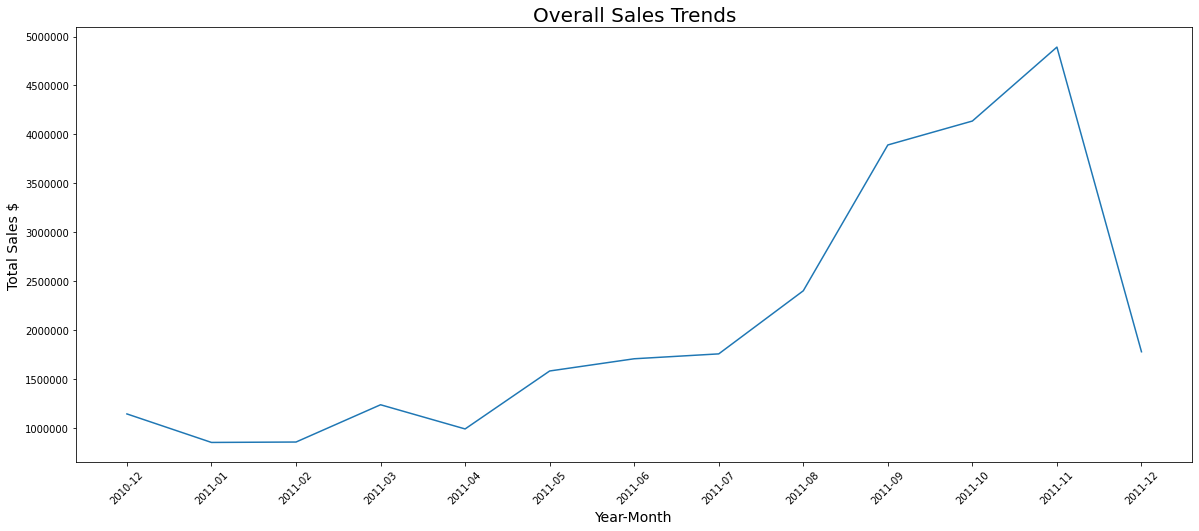

In [22]:
#Settting figure size
plt.figure(figsize = (20,8))

plt.plot(df_trend_overall['MonthYear'], df_trend_overall['Sales'], label = 'all channels')

#Format figure
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales $', fontsize=14)
plt.xlabel('Year-Month', fontsize=14)
plt.title("Overall Sales Trends", fontsize=20)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

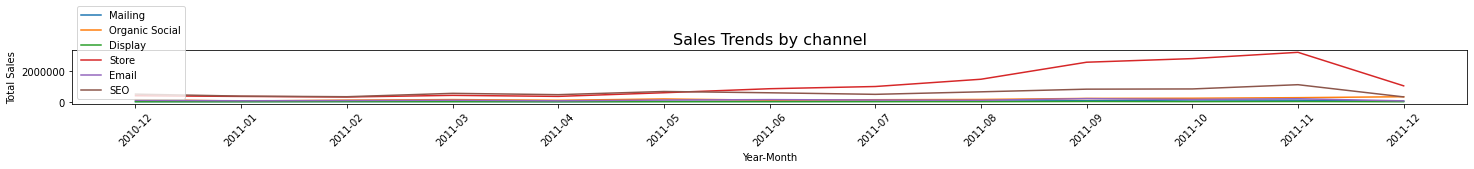

In [23]:
#Settting figure size
plt.figure(figsize = (25,1))

#plot all channels on one figure
plt.plot(df_trend_mailing['MonthYear'], df_trend_mailing['Sales'], label = 'Mailing')
plt.plot(df_trend_os['MonthYear'], df_trend_os['Sales'], label = 'Organic Social')
plt.plot(df_trend_display['MonthYear'], df_trend_display['Sales'], label = 'Display')
plt.plot(df_trend_store['MonthYear'], df_trend_store['Sales'], label = 'Store')
plt.plot(df_trend_email['MonthYear'], df_trend_email['Sales'], label = 'Email')
plt.plot(df_trend_seo['MonthYear'], df_trend_seo['Sales'], label = 'SEO')

#Format figure
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.legend()
plt.title("Sales Trends by channel", fontsize=16)
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

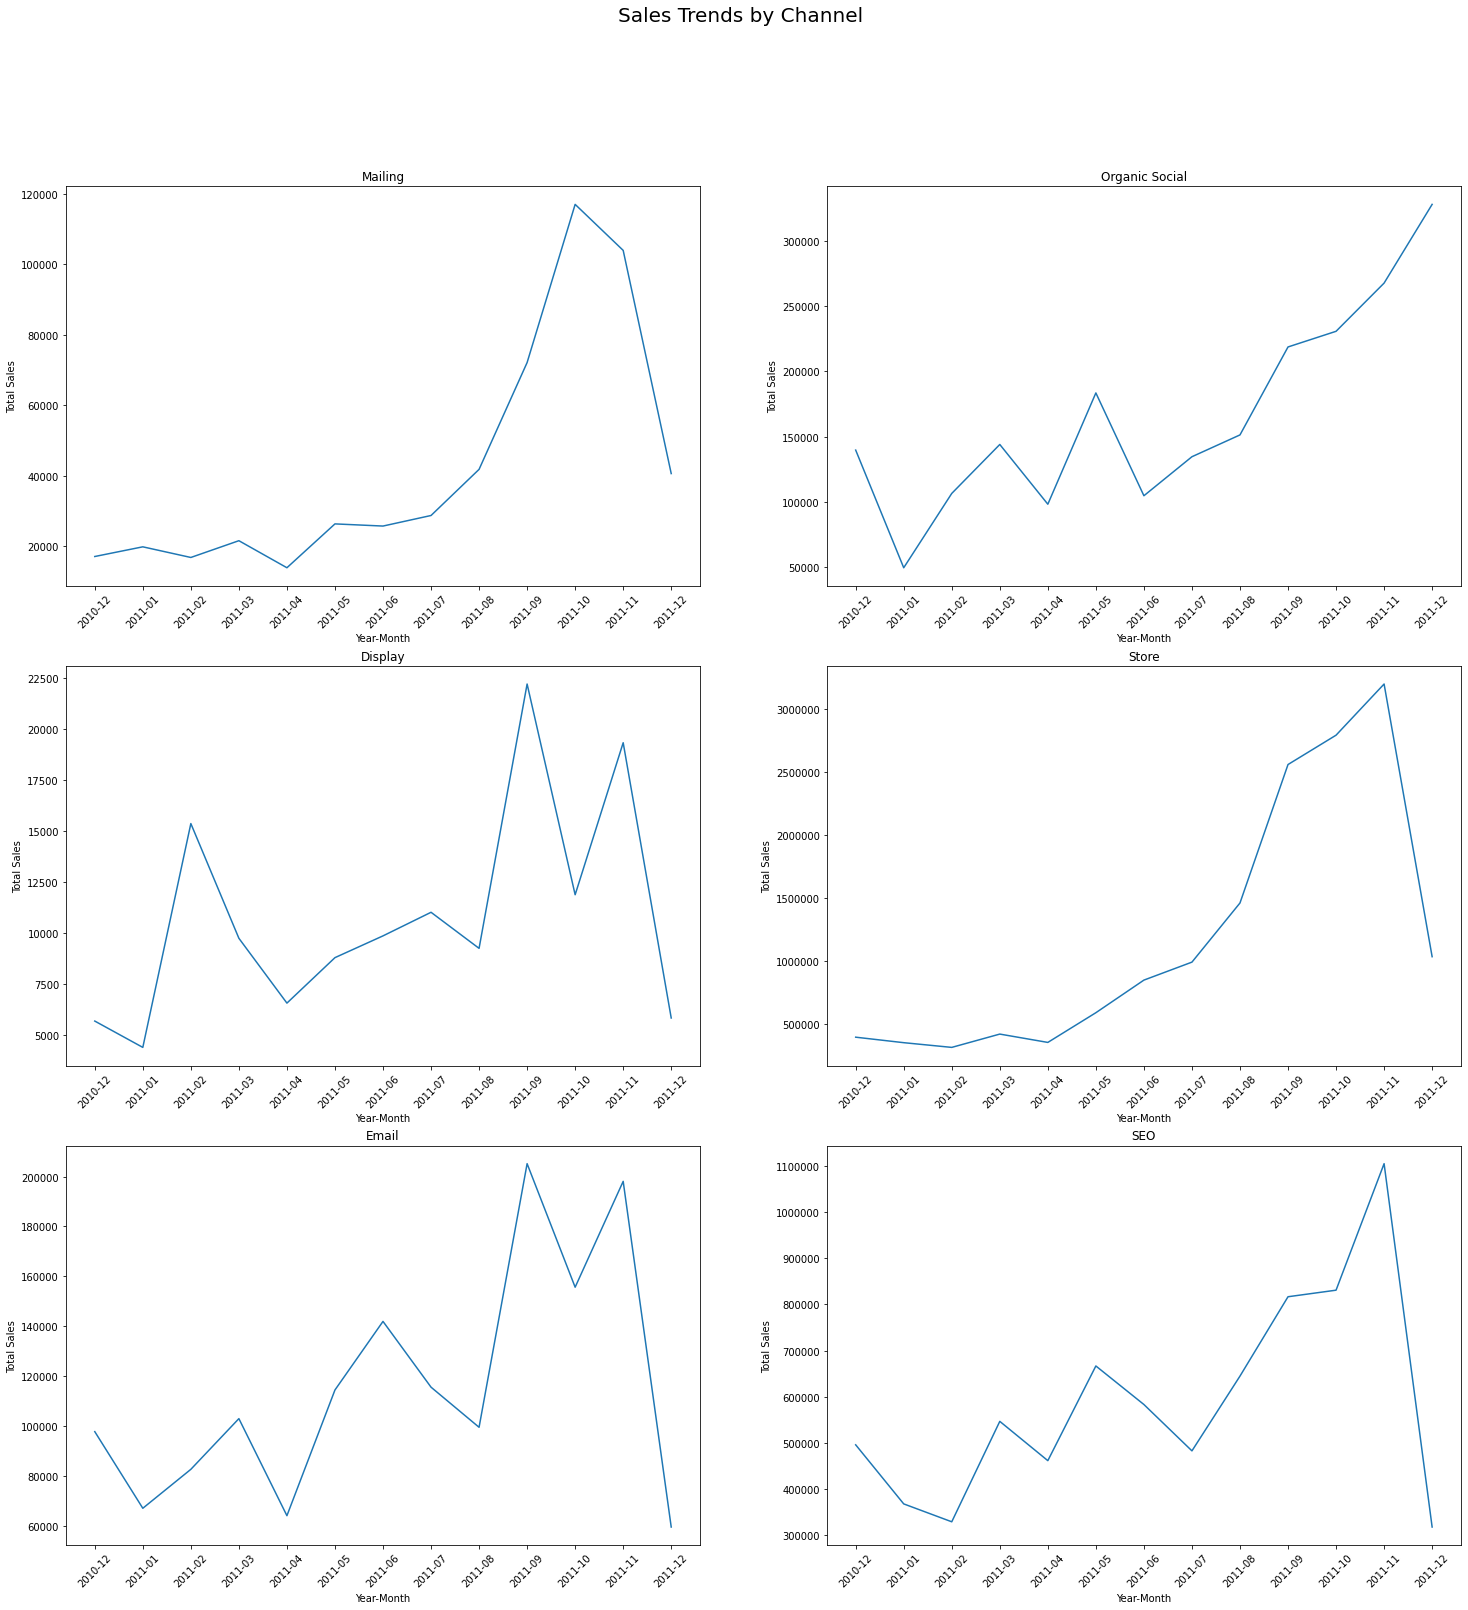

In [24]:
plt.figure(figsize = (25,25))
#subplot all channels
plt.suptitle('Sales Trends by Channel', fontsize=20)

plt.subplot(3,2,1)
plt.plot(df_trend_mailing['MonthYear'], df_trend_mailing['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('Mailing')

plt.subplot(3,2,2)
plt.plot(df_trend_os['MonthYear'], df_trend_os['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('Organic Social')

plt.subplot(3,2,3)
plt.plot(df_trend_display['MonthYear'], df_trend_display['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('Display')

plt.subplot(3,2,4)
plt.plot(df_trend_store['MonthYear'], df_trend_store['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('Store')

plt.subplot(3,2,5)
plt.plot(df_trend_email['MonthYear'], df_trend_email['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('Email')

plt.subplot(3,2,6)
plt.plot(df_trend_seo['MonthYear'], df_trend_seo['Sales'])
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Total Sales')
plt.xlabel('Year-Month')
plt.title('SEO')

plt.show()

In [25]:
df['InvoiceDay'].max()

Timestamp('2011-12-09 00:00:00')

In [26]:
df_Organic_Social['InvoiceDay'].max()

Timestamp('2011-12-09 00:00:00')

In [27]:
df_Email['InvoiceDay'].max()

Timestamp('2011-12-09 00:00:00')

In [28]:
df['InvoiceDay'].min()

Timestamp('2010-12-01 00:00:00')

**Takeaways:**
1. when we look at overall sales we can see that the beginning of the year Jan & Feb see the lowest sales totals
2. Overall sales start rising in April, peaking in November.
3. Sales drop drastically in December(2011)
       a. However this is can likely be attributed to not having a full months Data in December 2011, our Data stops at 2011-12-09
4. The store channel is driving sales totals starting in May.
5. The organic Social channel is the only one that continues to trend upwards in December(2011)
6. All other channels, with exception of organic social, display significant drops after November(2011)

### What are the top 10 products by sale?

In [29]:
 df.head()

,SalesOrder,SKU,Description,UnitPrice,CustomerID,Channel,State,InvoiceDay,Sales,Quantity,DayOfWeek,DayNum,Month,MonthNum,Year,MonthYear
0,580636,22474,SPACEBOY TV DINNER TRAY,1.95,16746,Mailing,IL,2011-12-05,31.20,16,Monday,5,December,12,2011,2011-12
1,581426,70006,LOVE HEART POCKET WARMER,0.79,17757,Organic Social,WA,2011-12-08,2.37,3,Thursday,8,December,12,2011,2011-12
2,575063,22697,GREEN REGENCY TEACUP AND SAUCER,2.95,16764,Display,TX,2011-11-08,8.85,3,Tuesday,8,November,11,2011,2011-11
3,544065,20726,LUNCH BAG WOODLAND,1.65,14346,Organic Social,TX,2011-02-15,13.20,8,Tuesday,15,February,2,2011,2011-02
4,568896,85049E,SCANDINAVIAN REDS RIBBONS,1.25,16361,Store,NY,2011-09-29,52.50,42,Thursday,29,September,9,2011,2011-09


In [30]:
#Group by product for overall, as well as each channel and pull out top 10
prod_sales_overall = pd.DataFrame(df.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_mailing = pd.DataFrame(df_mailing.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_os = pd.DataFrame(df_Organic_Social.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_Display = pd.DataFrame(df_Display.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_Store = pd.DataFrame(df_Store.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_Email = pd.DataFrame(df_Email.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]
prod_sales_SEO = pd.DataFrame(df_SEO.groupby('Description').sum()['Sales']).sort_values('Sales', ascending = False)[:10]

In [31]:
prod_sales_overall

,Sales
Description,
JUMBO BAG RED RETROSPOT,317028.10
REGENCY CAKESTAND 3 TIER,306216.82
RABBIT NIGHT LIGHT,294873.42
WHITE HANGING HEART T-LIGHT HOLDER,268004.42
"PAPER CRAFT , LITTLE BIRDIE",255577.92
ASSORTED COLOUR BIRD ORNAMENT,208329.21
POSTAGE,205640.10
PARTY BUNTING,173037.96
BLACK RECORD COVER FRAME,158449.39


In [32]:
prod_sales_mailing

,Sales
Description,
BLACK RECORD COVER FRAME,10122.36
ALARM CLOCK BAKELIKE PINK,9373.59
JAM MAKING SET PRINTED,7408.57
DOORMAT KEEP CALM AND COME IN,7275.06
SET OF 3 CAKE TINS PANTRY DESIGN,6701.42
LANDMARK FRAME CAMDEN TOWN,6658.85
JUMBO BAG RED RETROSPOT,6424.52
Manual,5957.28
DOG LICENCE WALL ART,5168.10


In [33]:
prod_sales_os

,Sales
Description,
"PAPER CRAFT , LITTLE BIRDIE",255577.92
POSTAGE,46665.93
REGENCY CAKESTAND 3 TIER,34210.57
JUMBO BAG RED RETROSPOT,18918.63
PARTY BUNTING,17283.20
WOOD BLACK BOARD ANT WHITE FINISH,17082.02
HEART OF WICKER LARGE,13591.85
ASSORTED COLOUR BIRD ORNAMENT,12217.90
SET OF 3 CAKE TINS PANTRY DESIGN,11865.73


In [34]:
prod_sales_Display

,Sales
Description,
GROW A FLYTRAP OR SUNFLOWER IN TIN,9913.12
RECIPE BOX PANTRY YELLOW DESIGN,5322.25
WHITE HANGING HEART T-LIGHT HOLDER,3797.35
CHILDRENS CUTLERY POLKADOT GREEN,3189.75
REGENCY CAKESTAND 3 TIER,2035.80
EDWARDIAN PARASOL NATURAL,1975.05
BLACK RECORD COVER FRAME,1884.84
PAPER CHAIN KIT EMPIRE,1775.20
SET OF TEA COFFEE SUGAR TINS PANTRY,1672.50


In [35]:
prod_sales_Store

,Sales
Description,
RABBIT NIGHT LIGHT,225027.63
JUMBO BAG RED RETROSPOT,206087.29
REGENCY CAKESTAND 3 TIER,151341.60
PICNIC BASKET WICKER 60 PIECES,126652.50
ASSORTED COLOUR BIRD ORNAMENT,125650.82
WHITE HANGING HEART T-LIGHT HOLDER,119205.51
PARTY BUNTING,93753.26
CHRISTMAS LIGHTS 10 REINDEER,89288.15
DOTCOM POSTAGE,88059.89


In [36]:
prod_sales_Email

,Sales
Description,
REGENCY TEAPOT ROSES,44467.70
REGENCY CAKESTAND 3 TIER,18282.00
WHITE HANGING HEART T-LIGHT HOLDER,17897.42
RETROSPOT HEART HOT WATER BOTTLE,16763.70
JUMBO BAG RED RETROSPOT,16288.30
ROTATING SILVER ANGELS T-LIGHT HLDR,14545.20
POSTAGE,14478.10
EMPIRE DESIGN ROSETTE,12816.68
PARTY BUNTING,12668.00


In [37]:
prod_sales_SEO

,Sales
Description,
WHITE HANGING HEART T-LIGHT HOLDER,111863.55
REGENCY CAKESTAND 3 TIER,95417.13
BLACK RECORD COVER FRAME,69560.58
JUMBO BAG RED RETROSPOT,68256.23
POSTAGE,57420.07
ASSORTED COLOUR BIRD ORNAMENT,56708.20
HALL CABINET WITH 3 DRAWERS,54526.92
RABBIT NIGHT LIGHT,50986.15
DOORMAT FAIRY CAKE,49410.03


**Takeaways:**
1. JUMBO BAG RED RETROSPOT shows up as our top overall seller and is also in 5 of the channels top 10


### What are the most selling products?

In [38]:
df.head()

,SalesOrder,SKU,Description,UnitPrice,CustomerID,Channel,State,InvoiceDay,Sales,Quantity,DayOfWeek,DayNum,Month,MonthNum,Year,MonthYear
0,580636,22474,SPACEBOY TV DINNER TRAY,1.95,16746,Mailing,IL,2011-12-05,31.20,16,Monday,5,December,12,2011,2011-12
1,581426,70006,LOVE HEART POCKET WARMER,0.79,17757,Organic Social,WA,2011-12-08,2.37,3,Thursday,8,December,12,2011,2011-12
2,575063,22697,GREEN REGENCY TEACUP AND SAUCER,2.95,16764,Display,TX,2011-11-08,8.85,3,Tuesday,8,November,11,2011,2011-11
3,544065,20726,LUNCH BAG WOODLAND,1.65,14346,Organic Social,TX,2011-02-15,13.20,8,Tuesday,15,February,2,2011,2011-02
4,568896,85049E,SCANDINAVIAN REDS RIBBONS,1.25,16361,Store,NY,2011-09-29,52.50,42,Thursday,29,September,9,2011,2011-09


In [39]:
# grouping product name and summing the quantity sold for totals
qty_overall = pd.DataFrame(df.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_mailing = pd.DataFrame(df_mailing.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_os = pd.DataFrame(df_Organic_Social.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_display = pd.DataFrame(df_Display.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_store = pd.DataFrame(df_Store.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_email = pd.DataFrame(df_Email.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]
qty_seo = pd.DataFrame(df_SEO.groupby('Description').sum()['Quantity']).sort_values('Quantity', ascending = False)[:10]

#### Overall

In [40]:
qty_overall

,Quantity
Description,
JUMBO BAG RED RETROSPOT,171529
RABBIT NIGHT LIGHT,150995
PACK OF 72 RETROSPOT CAKE CASES,140956
WORLD WAR 2 GLIDERS ASSTD DESIGNS,137519
ASSORTED COLOUR BIRD ORNAMENT,131505
"PAPER CRAFT , LITTLE BIRDIE",122874
POPCORN HOLDER,106453
ASSTD DESIGN 3D PAPER STICKERS,98578
WHITE HANGING HEART T-LIGHT HOLDER,95006


#### Mailing

In [41]:
qty_mailing

,Quantity
Description,
JAM MAKING SET PRINTED,5426
ASSORTED COLOURS SILK FAN,3744
JUMBO BAG RED RETROSPOT,3543
BLACK RECORD COVER FRAME,2980
POPCORN HOLDER,2950
ALARM CLOCK BAKELIKE PINK,2577
ASSORTED COLOUR BIRD ORNAMENT,2517
WORLD WAR 2 GLIDERS ASSTD DESIGNS,2355
SILVER GLITTER FLOWER VOTIVE HOLDER,2274


#### Organic Social

In [42]:
qty_os

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",122874
WORLD WAR 2 GLIDERS ASSTD DESIGNS,16920
JUMBO BAG RED RETROSPOT,10325
PACK OF 72 RETROSPOT CAKE CASES,9243
PACK OF 12 LONDON TISSUES,7995
ASSORTED COLOUR BIRD ORNAMENT,7606
POPCORN HOLDER,7175
PACK OF 60 PINK PAISLEY CAKE CASES,7102
VICTORIAN GLASS HANGING T-LIGHT,6734


#### Display

In [43]:
qty_display

,Quantity
Description,
GROW A FLYTRAP OR SUNFLOWER IN TIN,9352
RECIPE BOX PANTRY YELLOW DESIGN,1665
WHITE HANGING HEART T-LIGHT HOLDER,1457
MINI JIGSAW DOLLY GIRL,1200
WORLD WAR 2 GLIDERS ASSTD DESIGNS,1011
CHILDRENS CUTLERY POLKADOT GREEN,849
60 TEATIME FAIRY CAKE CASES,791
HANGING MINI COLOURED BOTTLES,740
LUNCH BAG RED RETROSPOT,738


#### Store

In [44]:
qty_store

,Quantity
Description,
RABBIT NIGHT LIGHT,113211
JUMBO BAG RED RETROSPOT,111746
ASSTD DESIGN 3D PAPER STICKERS,97763
ASSORTED COLOUR BIRD ORNAMENT,79994
PACK OF 72 RETROSPOT CAKE CASES,79678
WORLD WAR 2 GLIDERS ASSTD DESIGNS,72094
POPCORN HOLDER,56097
RED HARMONICA IN BOX,52656
PINK BLUE FELT CRAFT TRINKET BOX,45843


#### Email

In [45]:
qty_email

,Quantity
Description,
EMPIRE DESIGN ROSETTE,15628
WORLD WAR 2 GLIDERS ASSTD DESIGNS,13516
JUMBO BAG RED RETROSPOT,8872
ROTATING SILVER ANGELS T-LIGHT HLDR,7512
PLACE SETTING WHITE HEART,7312
PACK OF 12 LONDON TISSUES,6604
WHITE HANGING HEART T-LIGHT HOLDER,6210
PACK OF 72 RETROSPOT CAKE CASES,6120
ASSORTED COLOUR BIRD ORNAMENT,5958


#### SEO

In [46]:
qty_seo

,Quantity
Description,
PACK OF 72 RETROSPOT CAKE CASES,44187
WHITE HANGING HEART T-LIGHT HOLDER,38413
POPCORN HOLDER,36774
JUMBO BAG RED RETROSPOT,36445
ASSORTED COLOUR BIRD ORNAMENT,35284
MINI PAINT SET VINTAGE,34084
WORLD WAR 2 GLIDERS ASSTD DESIGNS,31623
RABBIT NIGHT LIGHT,27546
HEART OF WICKER SMALL,24565


**Takeaways:**

Promotions can be run based on each channels "hot" items

### What channels have the highest sales by Month

In [47]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
sales = pd.DataFrame(df.groupby(['Channel', 'MonthYear']).sum()['Sales']).reset_index().sort_values('MonthYear')

In [48]:
sales.sort_values('MonthYear')

,Channel,MonthYear,Sales
0,Display,2010-12,5663.500000000
26,Mailing,2010-12,17125.820000000
52,SEO,2010-12,495526.140000000
13,Email,2010-12,97807.180000000
65,Store,2010-12,391650.450000003
...,...,...,...
38,Mailing,2011-12,40648.180000000
51,Organic Social,2011-12,327761.750000001
25,Email,2011-12,59584.140000000
12,Display,2011-12,5813.990000000


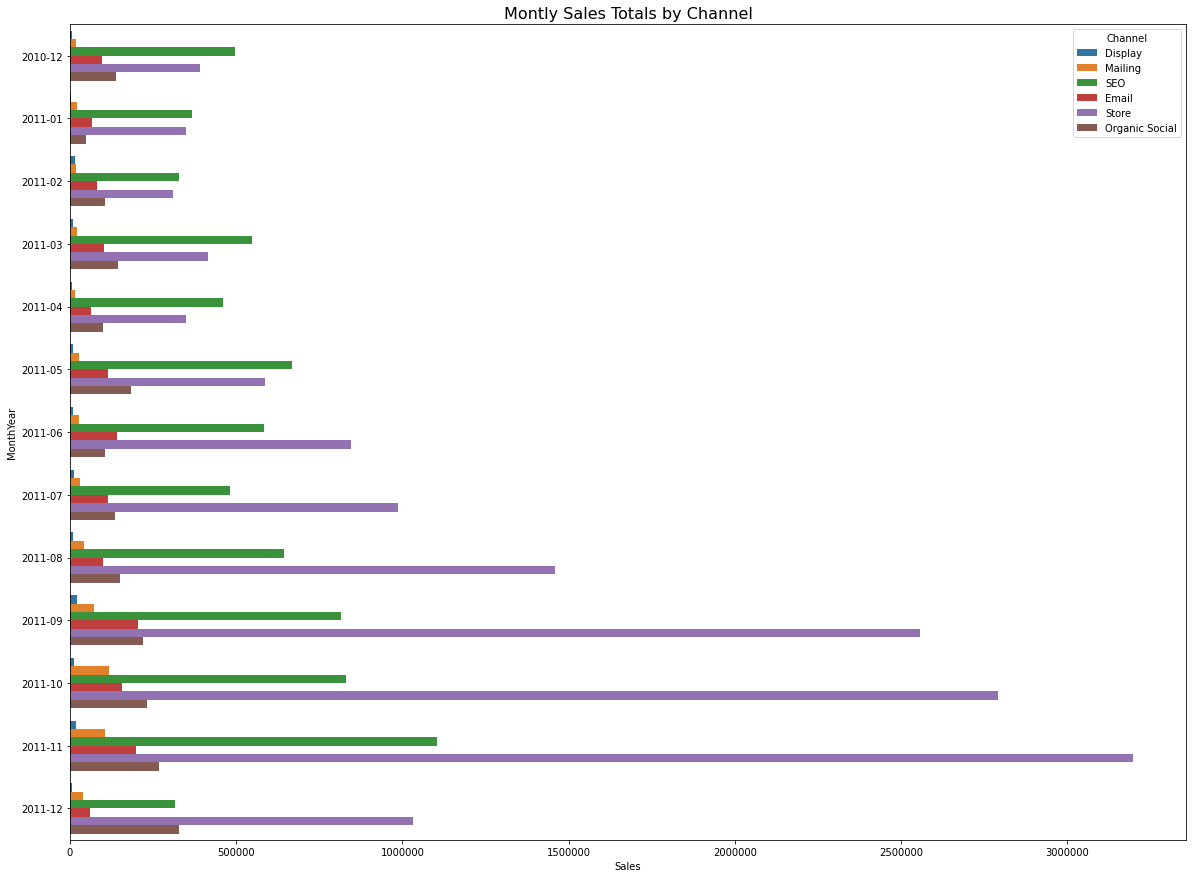

In [49]:
plt.figure(figsize = (20,15))
sns.barplot(data = sales, y = 'MonthYear', x = 'Sales', hue = 'Channel')
plt.ticklabel_format(style='plain', axis='x')
plt.title('Montly Sales Totals by Channel', fontsize = 16)
plt.show()

**Takeaways:**
1. The Store and SEO channel tend to have the most sales per month
2. Display channel regularly has the lowest sales totals
3. As we already learned, we do not have a full months  worth of Data for Dec 2011, that being said we can clearly see that Sales totals for Organic Social and Store are already up from Dec 2010.

### What day of the week has the most sales?

In [50]:
dow_sales_totals = pd.DataFrame(df.groupby(['DayOfWeek']).sum()['Sales']).reset_index().sort_values('Sales').sort_values('Sales', ascending = False)

In [51]:
dow_sales_totals['Sales'] = dow_sales_totals['Sales'].map('{:,.2f}'.format)

In [52]:
dow_sales_totals

,DayOfWeek,Sales
3,Thursday,"6,354,387.34"
4,Tuesday,"5,001,158.82"
5,Wednesday,"4,885,299.36"
0,Friday,"4,323,247.63"
1,Monday,"4,082,553.33"
2,Sunday,"2,618,766.57"


**Takeaways**
1. Start promotions on Sunday to drive up revenue

### Which States have the most sales totals?

In [53]:
sate_total_sales = pd.DataFrame(df.groupby(['State']).sum()['Sales']).reset_index().sort_values('Sales').sort_values('Sales', ascending = False)[:10]
sate_total_sales['Sales'] = sate_total_sales['Sales'].map('{:,.2f}'.format)

In [54]:
sate_total_sales

,State,Sales
3,CA,"3,691,420.89"
41,TX,"2,483,212.27"
7,FL,"2,306,719.33"
1,AL,"1,592,964.22"
12,IL,"1,385,073.40"
25,NC,"1,208,123.41"
8,GA,"1,182,351.69"
32,NY,"1,161,386.26"
36,PA,"884,972.63"
33,OH,"869,054.55"


**Takeaways**
1. Overall California has the most sales

## Modeling - By Channel

In this section I will:
1. Create appropriate columns for Prophet to use (DS and Y)
2. Fit.train. predict

In [55]:
#Since column names are the same across all df we create 1 variable, only need 2 columns.
col_to_keep = ['InvoiceDay', 'Sales']

In [56]:
#create df for each channel
mailing = df_mailing[col_to_keep]
organic_social = df_Organic_Social[col_to_keep]
Display = df_Display[col_to_keep]
Store = df_Store[col_to_keep]
Email = df_Email[col_to_keep]
SEO = df_SEO[col_to_keep]

#set prophet rquired column names
mailing.columns = ['ds', 'y']
organic_social.columns = ['ds', 'y']
Display.columns = ['ds', 'y']
Store.columns = ['ds', 'y']
Email.columns = ['ds', 'y']
SEO.columns = ['ds', 'y']

In [57]:
#create function for modeling
def prophet_forecast(df, periods=90):
    '''
    This function takes in a df prepped for prophet 
    containg the DS and y columns only. Also takes in a daily forecasting 
    number that is autset at 90 days. Returns in this order
    Automatically:
    1. Plot of Predictions
    2. Plot of components
    Save in varaibles to view:
    3. RMSE
    4. Forcast df
    5. r2
    '''
    #create and fit the model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True, 
        daily_seasonality=False)
    m.fit(df)
    
    #future df/placeholder periods set to 90 and day so we can predict out 90days
    future = m.make_future_dataframe(periods=periods,freq='d',include_history=True)
    
    #predict the future
    forecast = m.predict(future)
    
    #Plot out predictions
    fig = m.plot(forecast)
    plt.legend(['Actual', 'Prediction', 'Uncertainty interval'])
    plt.title('Predictions and Actuals Plotted')
    plt.show()
    
    #Plot out the compontents
    fig2 = m.plot_components(forecast)
    plt.suptitle('Compomets of Model')
    plt.show()
    
    #find out actual sales points and predicted sales point
    predictions = forecast.iloc[-len(df):]['yhat']
    actuals = df['y']
    
    
    #Evaluate the model
    RMSE = round(np.sqrt(mean_squared_error(predictions, actuals)))#root mean squared error
    metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
    

    #Create df with our daily forecast
    forecast = metric_df[['ds', 'yhat']].tail(90)
    
    #Evaluate the 
    metric_df.dropna(inplace=True)
    r2 = r2_score(metric_df.y, metric_df.yhat)
    
                 
    return RMSE, forecast, r2

### Mailing

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


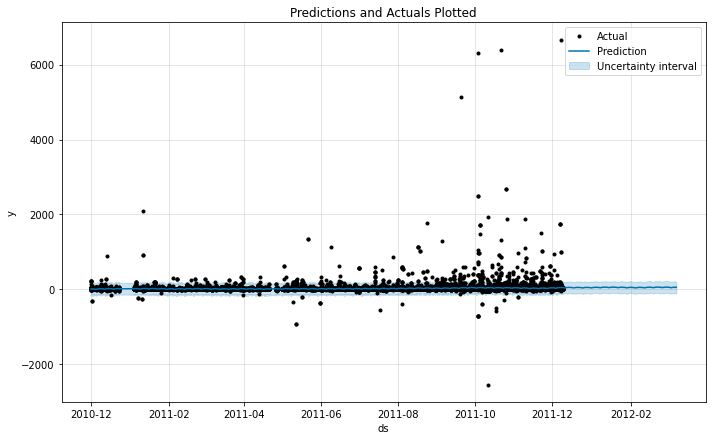

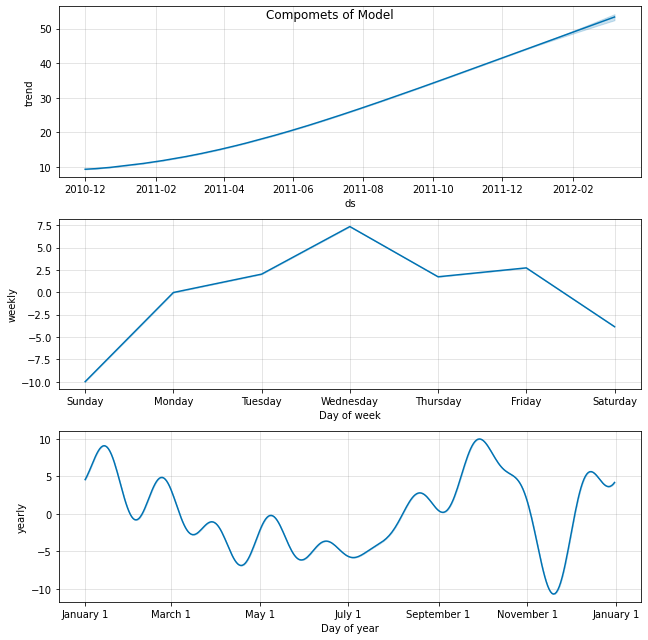

In [58]:
RMSE_mailing, forecast_mailing, r2_mailing = prophet_forecast(mailing)

In [59]:
print(f'RMSE:{RMSE_mailing}')

RMSE:123.0


In [60]:
print(f'R2:{r2_mailing}')

R2:0.00899997753193904


### Organic Social

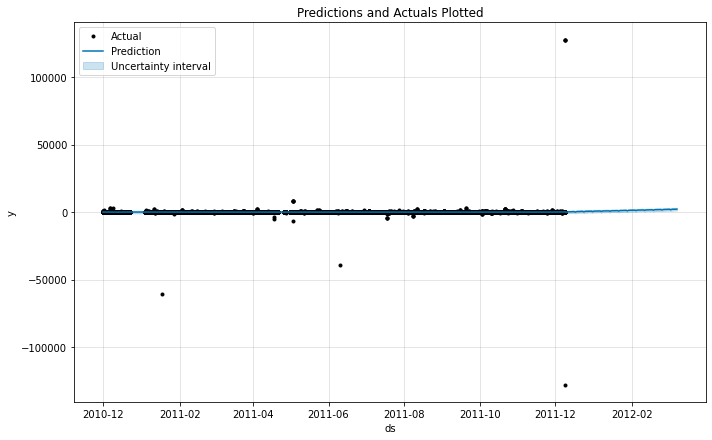

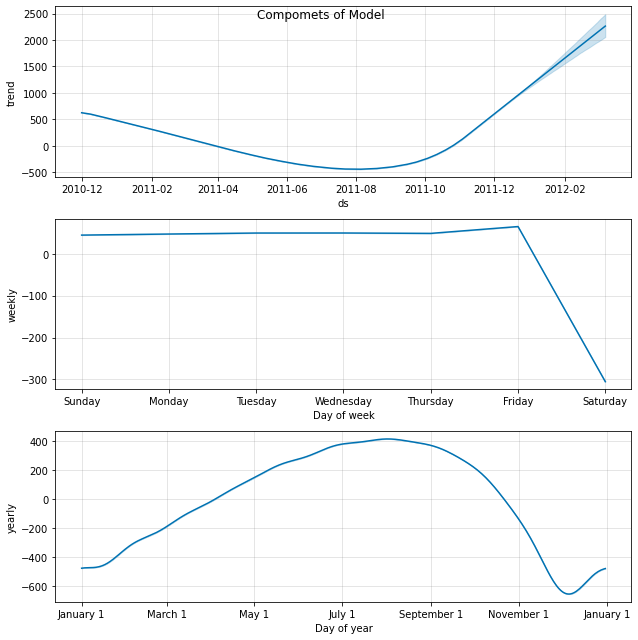

In [61]:
RMSE_organic_social, forecast_organic_social, r2_organic_social = prophet_forecast(organic_social)

In [62]:
print(f'RMSE:{RMSE_organic_social}')

RMSE:766.0


In [63]:
print(f'R2:{r2_organic_social}')

R2:-0.0007223621373690925


### Display

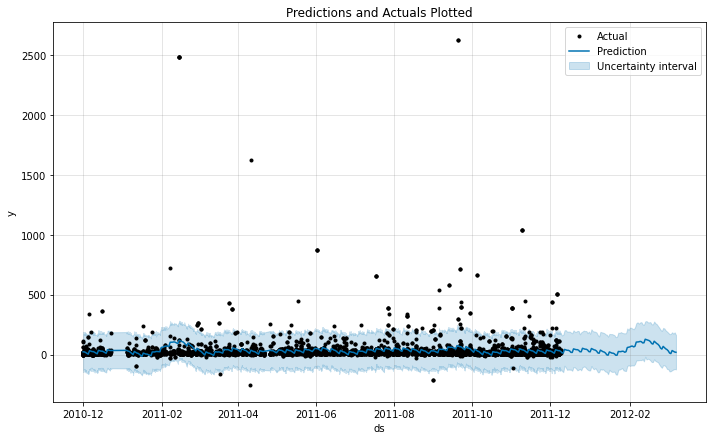

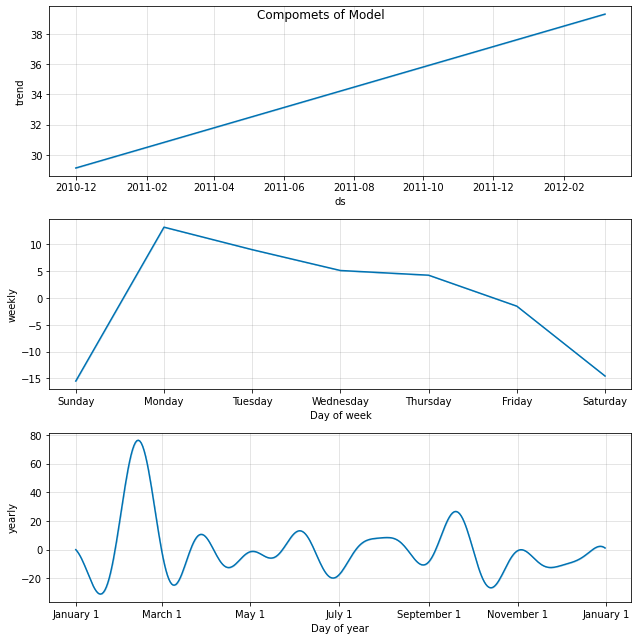

In [64]:
RMSE_Display, forecast_Display, r2_Display = prophet_forecast(Display)

In [65]:
print(f'RMSE:{RMSE_Display}')

RMSE:124.0


In [66]:
print(f'R2:{r2_Display}')

R2:0.02751551714961098


### Store

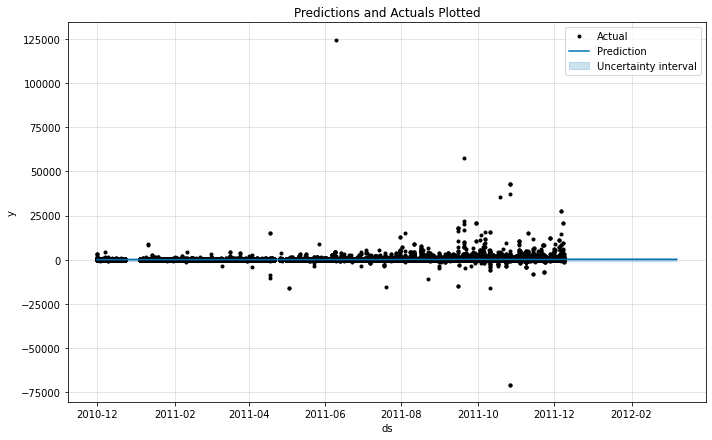

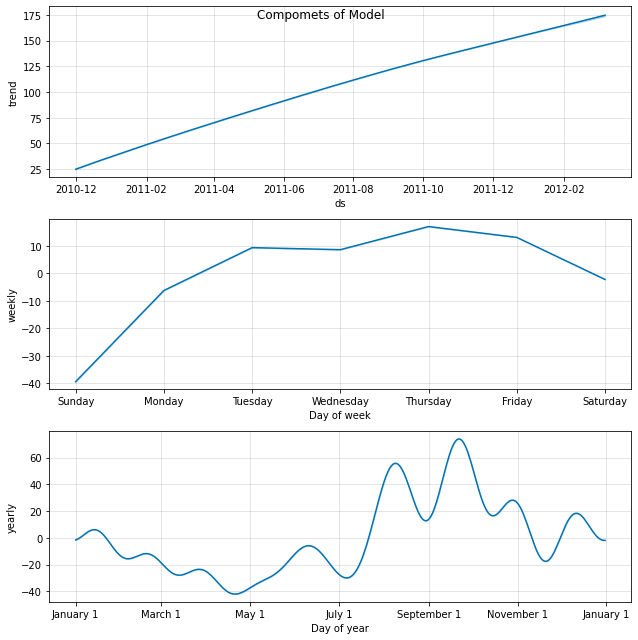

In [67]:
RMSE_Store, forecast_Store, r2_Store = prophet_forecast(Store)

In [68]:
print(f'RMSE:{RMSE_Store}')

RMSE:665.0


In [69]:
print(f'R2:{r2_Store}')

R2:0.006928119261596755


### Email

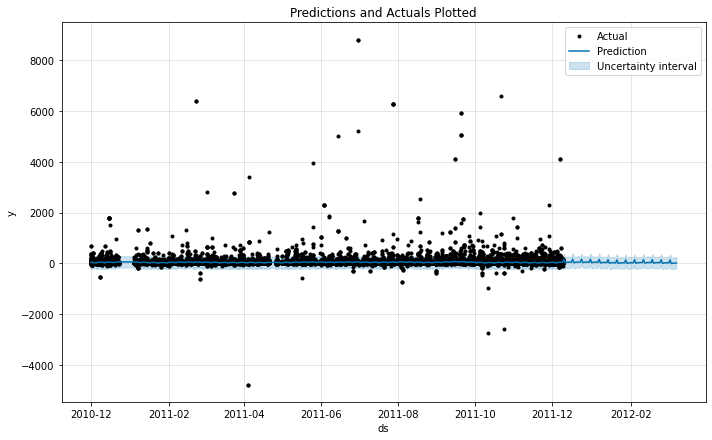

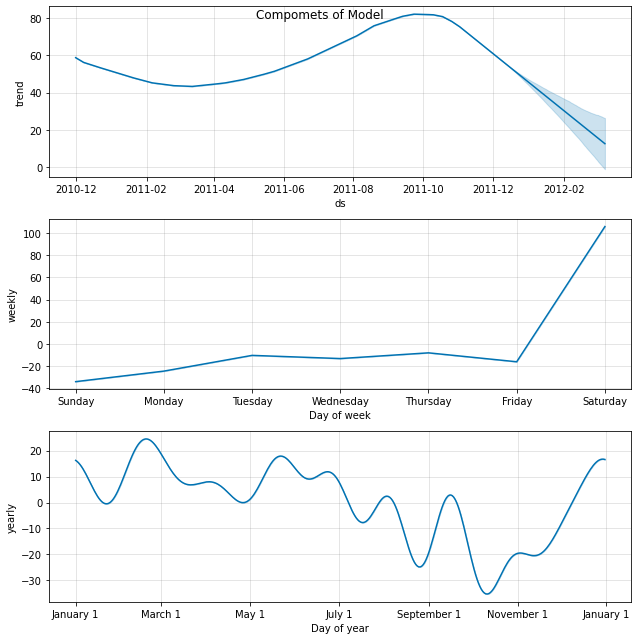

In [70]:
RMSE_Email, forecast_Email, r2_Email = prophet_forecast(Email)

In [71]:
print(f'RMSE:{RMSE_Email}')

RMSE:174.0


In [72]:
print(f'R2:{r2_Email}')

R2:0.005458344757659939


### SEO

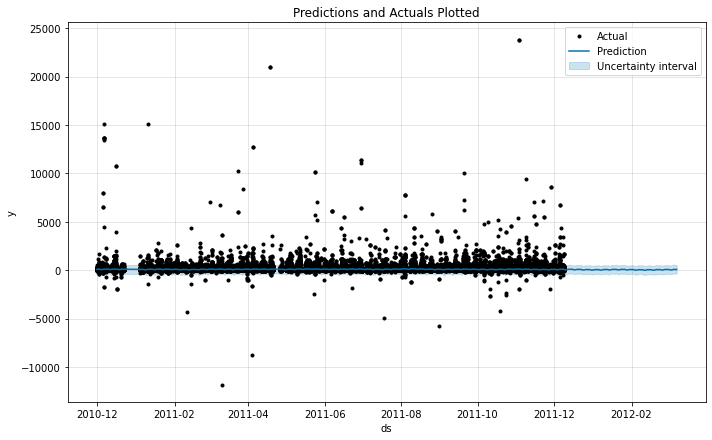

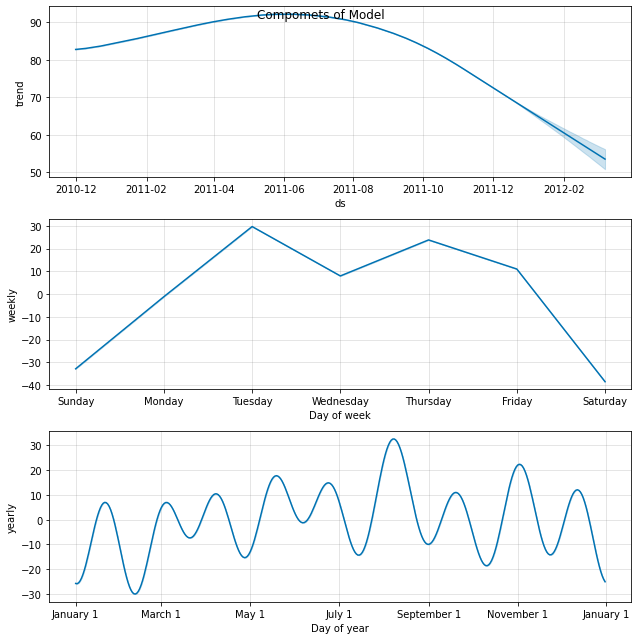

In [73]:
RMSE_SEO, forecast_SEO, r2_SEO = prophet_forecast(SEO)

In [74]:
print(f'RMSE:{RMSE_SEO}')

RMSE:349.0


In [75]:
print(f'R2:{r2_SEO}')

R2:0.005251586147336451


**Takeaways:**
- Prophet is probably not the best tool for this forecast.
- All my r2 were under 1
- RMSE high for the datapoints given